# Developing an AI application
Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications.
In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using this dataset of 102 flower categories, you can see a few examples below.

The project is broken down into multiple steps:
Load and preprocess the image dataset
Train the image classifier on your dataset
Use the trained classifier to predict image content
We'll lead you through each part which you'll implement in Python.
When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.
First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.
Please make sure if you are running this notebook in the workspace that you have chosen GPU rather than CPU mode.

In [37]:
# Imports here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import matplotlib.pyplot as plt

import torch
import numpy as np
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from workspace_utils import active_session
from PIL import Image
from collections import OrderedDict
import json

# Load the data
Here you'll use torchvision to load the data (documentation). The data should be included alongside this notebook, otherwise you can download it here. The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.
The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.
The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's [0.485, 0.456, 0.406] and for the standard deviations [0.229, 0.224, 0.225], calculated from the ImageNet images. These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [38]:
os.getcwd()
!pwd
data_dir = 'pets'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'
using_gpu = torch.cuda.is_available()


/Users/jennifercooper/Projects/Machine Learning/PyTorchTraining


In [51]:
# TODO: Define your transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])
testval_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])

# TODO: Load the datasets with ImageFolder
image_trainset = datasets.ImageFolder(train_dir, transform=train_transforms)
image_testset = datasets.ImageFolder(test_dir, transform=testval_transforms)
image_valset = datasets.ImageFolder(valid_dir, transform=testval_transforms)

# TODO: Using the image datasets and the trainforms, define the dataloaders
image_trainloader = torch.utils.data.DataLoader(image_trainset, batch_size=64, shuffle=True)
image_testloader = torch.utils.data.DataLoader(image_testset, batch_size=64, shuffle=True)
image_valloader = torch.utils.data.DataLoader(image_valset, batch_size=64, shuffle=True)

In [52]:
with open('cat_to_name_petclassifier.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier
Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from torchvision.models to get the image features. Build and train a new feed-forward classifier using those features.
We're going to leave this part up to you. Refer to the rubric for guidance on successfully completing this section. Things you'll need to do:
Load a pre-trained network (If you need a starting point, the VGG networks work great and are straightforward to use)
Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
Train the classifier layers using backpropagation using the pre-trained network to get the features
Track the loss and accuracy on the validation set to determine the best hyperparameters
We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!
When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.
One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.


In [53]:
# TODO: Build and train your network
epochs = 4
lr = 0.001
print_every = 10

In [54]:
# Freeze parameters so we don't backprop through them
hidden_layers = [10240, 1024]
def make_model(structure, hidden_layers, lr):
    if structure=="densenet161":
        model = models.densenet161(pretrained=True)
        input_size = 2208
    else:
        model = models.vgg16(pretrained=True)
        input_size = 25088
    output_size = 102
    for param in model.parameters():
        param.requires_grad = False

    classifier = nn.Sequential(OrderedDict([
                              ('dropout',nn.Dropout(0.5)),
                              ('fc1', nn.Linear(input_size, hidden_layers[0])),
                              ('relu1', nn.ReLU()),
                              ('fc2', nn.Linear(hidden_layers[0], hidden_layers[1])),
                              ('relu2', nn.ReLU()),
                              ('fc3', nn.Linear(hidden_layers[1], output_size)),
                              ('output', nn.LogSoftmax(dim=1))
                              ]))

    model.classifier = classifier
    return model

model = make_model('vgg16', hidden_layers, lr)

In [55]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=lr)

In [64]:
def cal_accuracy(model, dataloader):
    validation_loss = 0
    accuracy = 0
    for i, (inputs,labels) in enumerate(dataloader):
                optimizer.zero_grad()
                inputs, labels = inputs.to('cuda') , labels.to('cuda')
                model.to('cuda')
                with torch.no_grad():    
                    outputs = model.forward(inputs)
                    validation_loss = criterion(outputs,labels)
                    ps = torch.exp(outputs).data
                    equality = (labels.data == ps.max(1)[1])
                    accuracy += equality.type_as(torch.FloatTensor()).mean()
                    
    validation_loss = validation_loss / len(dataloader)
    accuracy = accuracy /len(dataloader)
    
    return validation_loss, accuracy

In [67]:
def cal_accuracy(model, dataloader):
    validation_loss = 0
    accuracy = 0
    for i, (inputs,labels) in enumerate(dataloader):
                optimizer.zero_grad()
                inputs, labels = inputs.to('cpu') , labels.to('cpu')
                model.to('cpu')
                with torch.no_grad():    
                    outputs = model.forward(inputs)
                    validation_loss = criterion(outputs,labels)
                    ps = torch.exp(outputs).data
                    equality = (labels.data == ps.max(1)[1])
                    accuracy += equality.type_as(torch.FloatTensor()).mean()
                    
    validation_loss = validation_loss / len(dataloader)
    accuracy = accuracy /len(dataloader)
    
    return validation_loss, accuracy

In [72]:
#with active_session():
    def my_DLM(model, image_trainloader, image_valloader, epochs, print_every, criterion, optimizer, device='cpu'):
        epochs = epochs
        print_every = print_every
        steps = 0

        # change to cuda
        model.to('cpu')

        for e in range(epochs):
            running_loss = 0
            for ii, (inputs, labels) in enumerate(image_trainloader):
                steps += 1

                inputs, labels = inputs.to('cpu'), labels.to('cpu')

                optimizer.zero_grad()

                # Forward and backward passes
                outputs = model.forward(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

                if steps % print_every == 0:
                    model.eval()
                    val_loss, train_ac = cal_accuracy(model, image_valloader)
                    print("Epoch: {}/{}... | ".format(e+1, epochs),
                          "Loss: {:.4f} | ".format(running_loss/print_every),
                          "Validation Loss {:.4f} | ".format(val_loss),
                          "Accuracy {:.4f}".format(train_ac))

                    running_loss = 0
    my_DLM(model, image_trainloader, image_valloader, epochs, print_every, criterion, optimizer, 'cpu')

Epoch: 1/4... |  Loss: 14.6691 |  Validation Loss 0.2326 |  Accuracy 0.7706
Epoch: 2/4... |  Loss: 0.2171 |  Validation Loss 0.0725 |  Accuracy 0.9209
Epoch: 3/4... |  Loss: 0.0416 |  Validation Loss 0.1637 |  Accuracy 0.8375
Epoch: 3/4... |  Loss: 0.2349 |  Validation Loss 0.1058 |  Accuracy 0.9566
Epoch: 4/4... |  Loss: 0.1558 |  Validation Loss 0.1076 |  Accuracy 0.9722


In [73]:
# TODO: Do validation on the test set
def testing(dataloader):
    model.eval()
    model.to('cpu')
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in image_testloader:
            inputs, labels = inputs.to('cpu'), labels.to('cpu')
            outputs = model(inputs)
            _ , prediction = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (prediction == labels.data).sum().item()
        print('Accuracy on the test set: %d %%' % (100 * correct / total))   
testing(image_testloader)

Accuracy on the test set: 94 %


In [76]:
model.class_to_idx = image_trainset.class_to_idx
# TODO: Save the checkpoint 

state = {
            'structure' :'vgg16',
            'learning_rate': lr,
            'epochs': epochs,
            'hidden_layers':hidden_layers,
            'state_dict':model.state_dict(),
            'class_to_idx':model.class_to_idx
}
torch.save(state, 'checkpoint_pet_classifier.pth')

In [77]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def loading_checkpoint(path):
    
    # Loading the parameters
    state = torch.load(path)
    lr = state['learning_rate']
    structure = state['structure']
    hidden_layers = state['hidden_layers']
    epochs = state['epochs']
    
    # Building the model from checkpoints
    model = make_model(structure, hidden_layers, lr)
    class_to_idx = state['class_to_idx']
    model.load_state_dict(state['state_dict'])
    
loading_checkpoint('checkpoint_pet_classifier.pth')

In [78]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
    pil_image = Image.open(image)
   
    image_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    img = image_transforms(pil_image)
    return img

In [80]:
image_path = (test_dir + '/1/' + 'IMG_0221.jpg')
processed_image = process_image(image_path)
processed_image

tensor([[[ 1.2385,  1.2557,  1.2043,  ...,  1.3755,  1.3755,  1.3413],
         [ 1.1700,  1.1529,  1.0502,  ...,  1.2899,  1.2557,  1.3755],
         [ 1.2043,  1.2214,  0.9817,  ...,  1.4098,  1.5468,  1.5810],
         ...,
         [-1.9980, -1.9809, -1.9638,  ..., -1.9124, -1.8953, -1.8953],
         [-1.9980, -1.9980, -1.9980,  ..., -1.8953, -1.8953, -1.8953],
         [-1.9980, -1.9980, -1.9980,  ..., -1.8953, -1.8953, -1.8953]],

        [[ 0.8704,  0.9055,  0.8880,  ...,  1.4482,  1.4482,  1.4482],
         [ 0.8704,  0.8529,  0.7479,  ...,  1.3606,  1.3606,  1.5007],
         [ 0.9580,  0.9580,  0.6779,  ...,  1.4832,  1.6758,  1.7108],
         ...,
         [-1.6155, -1.6331, -1.6155,  ..., -1.6856, -1.6681, -1.6681],
         [-1.6155, -1.6155, -1.6331,  ..., -1.6681, -1.6681, -1.6681],
         [-1.6155, -1.6155, -1.6155,  ..., -1.6681, -1.6681, -1.6681]],

        [[ 0.6008,  0.6356,  0.6356,  ...,  1.1411,  1.1411,  1.1411],
         [ 0.5834,  0.5659,  0.4962,  ...,  1

In [81]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

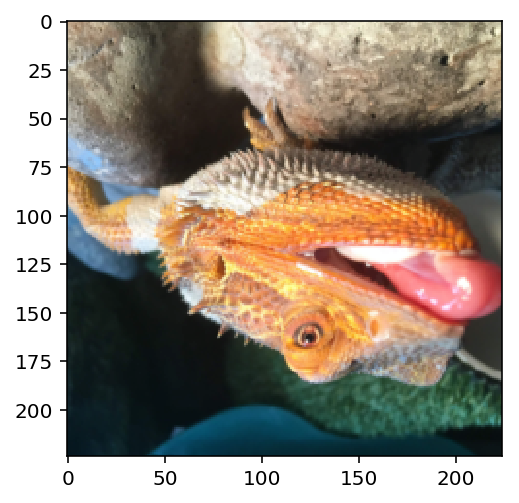

In [82]:
image_path = (test_dir + '/1/' + 'IMG_0221.jpg')
imshow(processed_image.numpy())

In [88]:
def predict(image_path, model, topk=4):
    ''' Predict the class (or classes) of an image using a trained deep learning model. topk is number of classes.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    model.eval()
    model.cpu()
    img = process_image(image_path)
    img = img.unsqueeze_(0)
    img = img.float()
    
    with torch.no_grad():
        output = model.forward(img)
        probs, classes = torch.topk(input=output, k=topk)
        top_prob = probs.exp()

    # Convert indices to classes
    idx_to_class = {val: key for key, val in model.class_to_idx.items()}
    top_classes = [idx_to_class[each] for each in classes.cpu().numpy()[0]]
        
    print('Top Classes: ', top_classes)
    print('Top Probs: ', top_prob)
    return top_prob, top_classes
    
    

In [90]:
image_path = (test_dir + '/1/' + 'IMG_0221.jpg')
probs, classes = predict(image_path, model)

# Converting from tensor to numpy-array
print(probs)
print(classes)

Top Classes:  ['1', '4', '3', '2']
Top Probs:  tensor([[0.7121, 0.1439, 0.1382, 0.0056]])
tensor([[0.7121, 0.1439, 0.1382, 0.0056]])
['1', '4', '3', '2']


Top Classes:  ['1', '4', '3', '2']
Top Probs:  tensor([[0.7121, 0.1439, 0.1382, 0.0056]])


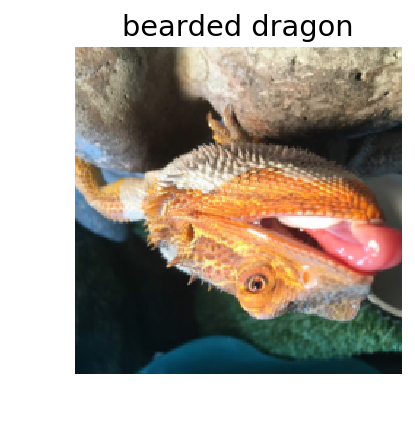

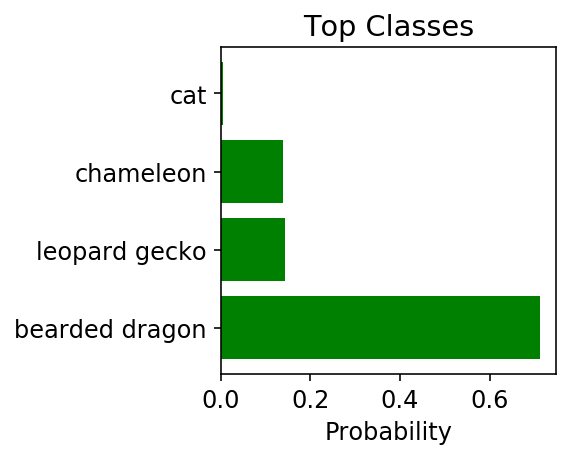

In [91]:
def sanity_checking():
    plt.rcParams["figure.figsize"] = (3,3)
    plt.rcParams.update({'font.size': 12})
    
    # Showing actual image
    image_path = (test_dir + '/1/' + 'IMG_0221.jpg')
    probs, classes = predict(image_path, model)
    #classes = classes.cpu().numpy()
    image_to_show = process_image(image_path)
    image = imshow(image_to_show.numpy(), ax = plt)
    image.axis('off')
    image.title(cat_to_name[str(classes[0])])
    image.show()
    
    # Showing Top Classes
    labels = []
    for class_index in classes:
        labels.append(cat_to_name[str(class_index)])
    y_pos = np.arange(len(labels))
    probs = probs[0]

    plt.barh(y_pos, probs, align='center', color='green')
    plt.yticks(y_pos, labels)
    plt.xlabel('Probability')
    plt.title('Top Classes')

    plt.show()

sanity_checking()